vae1　オートエンコーダー ( net/lossクラス分離 )

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/notebook


In [4]:
! pip install lark-parser

In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータ

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(x_train.shape)

torch.Size([1797, 64])


サンプルデータの図化

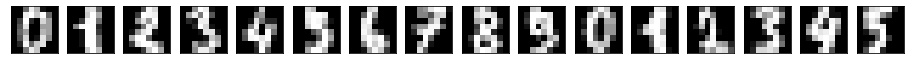

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [8]:
def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = torch.sum(e) / len(y)
  return z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * torch.sum( g ) / len(mean)
  return y

import torch.distributions as tdist

# original class
class Net1(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net1, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    #self.bn1 = nn.BatchNorm1d(n_mid)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    #self.drop1 = nn.Dropout(p=0.2)
    self.eps = e

    nn.init.constant_(self.fc1.bias,0)
    nn.init.constant_(self.fc2_mean.bias,0)
    nn.init.constant_(self.fc2_var.bias,0)
    nn.init.constant_(self.fc3.bias,0)
    nn.init.constant_(self.fc4.bias,0)
  
  def forward( self, x ):
    # encoder
    self.x2 = F.relu( self.fc1(x) )
    #self.x2 = self.bn1(self.x1)
    self.mean    = self.fc2_mean(self.x2)
    self.log_var = self.fc2_var(self.x2)

    # reparametrization
    #eps = torch.randn( n_batch, n_z )
    eps = torch.randn( self.mean.shape )
    #nm = tdist.Normal( 0.0, 1.0 ) #torch.tensor([0.0]), torch.tensor([1.0]))
    #eps = nm.sample([ n_batch, n_z ])
    #eps = torch.normal(0.0,1.0,[32,2])
    #print("eps",eps.size(),eps)
    self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )
    #self.z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )

    # decoder
    self.y2 = F.relu( self.fc3(self.z) )
    #self.y2 = self.drop1(self.y1)
    y = torch.sigmoid( self.fc4(self.y2) )
    self.out = y 
    
    e1 = reconstruction( y, x )
    e2 = kl_divergence( self.mean, self.log_var )
    #print("e1,e2",e1,e2)
    self.loss1=e1
    self.loss2=e2
    
    return -(e1+e2)

class VAE(torch.nn.Module):
  
  class Net(torch.nn.Module):
    def __init__( self, n_in, n_mid, n_out, n_z, e ):
      super().__init__()
      print("create net class")
      self.fc1 = nn.Linear(n_in, n_mid)
      #self.bn1 = nn.BatchNorm1d(n_mid)
      self.fc2_mean = nn.Linear(n_mid, n_z)
      self.fc2_var  = nn.Linear(n_mid, n_z)
      self.fc3 = nn.Linear(n_z  ,n_mid)
      self.fc4 = nn.Linear(n_mid,n_out)
      #self.drop1 = nn.Dropout(p=0.2)
      self.eps = e
    
      nn.init.constant_(self.fc1.bias,0)
      nn.init.constant_(self.fc2_mean.bias,0)
      nn.init.constant_(self.fc2_var.bias,0)
      nn.init.constant_(self.fc3.bias,0)
      nn.init.constant_(self.fc4.bias,0)
    
    def forward( self, x ):
      # encoder
      self.x2 = F.relu( self.fc1(x) )
      #self.x2 = self.bn1( self.x1 )
      m1 = self.fc2_mean( self.x2 )
      v1 = self.fc2_var( self.x2 )
      self.mean = m1;
      self.log_var = v1;

      # reparametrization
      #eps = torch.randn( n_batch, n_z )
      eps = torch.randn( self.mean.shape )
      #nm = tdist.Normal( 0.0, 1.0 ) #torch.tensor([0.0]), torch.tensor([1.0]))
      #eps = nm.sample([ n_batch, n_z ])
      #eps = torch.normal(0.0,1.0,[32,2])
      #print("eps",eps.size(),eps)
      self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )
      #self.z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )

      # decoder
      self.y2 = F.relu( self.fc3(self.z) )
      #self.y2 = self.drop1(self.y1)
      y = torch.sigmoid( self.fc4(self.y2) )
      self.out = y 
      return y, m1, v1
  
  class Loss(torch.nn.Module):
    def __init__(self):
      super().__init__()
      print("create loss class")

    def forward( self, y, x, mean, log_var ):
      e1 = reconstruction( y, x )
      e2 = kl_divergence( mean, log_var )

      self.loss1 = e1
      self.loss2 = e2
      #print("e1,e2",e1,e2)
      return -(e1+e2)
  
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super( VAE, self ).__init__()
    print("create vae class")
    self.net  = self.Net( n_in, n_mid, n_out, n_z, e )
    self.loss = self.Loss()

  def forward( self, x ):
    y, m1, v1 = self.net(x)
    output = self.loss( y, x, m1, v1 )
    return output

In [9]:
def generate_json( json_path, input, e ):

    #model = Net( n_in, n_mid, n_out, n_z, e )
    model = VAE( n_in, n_mid, n_out, n_z, e )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [10]:
torch.manual_seed( 1 )

project = 'vae1cls'
json_path = './network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#print(type(x))
#print(x.shape)
x.requires_grad = True

e = torch.randn( n_batch, 2 )
#print("eps",e)

model = generate_json( json_path, x, e )

create vae class
create net class
create loss class
[SAVE] ./network/vae1cls.json


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:985: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 1 element(s) (out of 1) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference 

skip: VAE/Net[net]/Linear[fc1]/weight/173
skip: VAE/Net[net]/Linear[fc1]/weight/173
skip: VAE/Net[net]/Linear[fc2_mean]/weight/172
skip: VAE/Net[net]/Linear[fc2_mean]/weight/172
skip: VAE/Net[net]/Linear[fc2_var]/weight/171
skip: VAE/Net[net]/Linear[fc2_var]/weight/171
skip: VAE/Net[net]/Linear[fc3]/weight/170
skip: VAE/Net[net]/Linear[fc3]/weight/170
skip: VAE/Net[net]/Linear[fc4]/weight/169
skip: VAE/Net[net]/Linear[fc4]/weight/169


In [12]:
CV.convert_json( project, "./src", model, x, json_path )

[JSON] ./network/vae1cls.json
{'name': 'VAE/Net[net]/Linear[fc1]/weight/175', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'VAE/Net[net]/Linear[fc1]/bias/174', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'VAE/Net[net]/Linear[fc2_mean]/weight/179', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'VAE/Net[net]/Linear[fc2_mean]/bias/178', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'VAE/Net[net]/Linear[fc2_var]/weight/182', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [20], 'sorted_id': 18}
{'name': 'VAE/Net[net]/Linear[fc2_var]/bias/181', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [20], 'sorted_id': 19}
{'name': 'VAE/Net[net]/Linear[fc3]/weight/193', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [28], 'so

In [13]:
# check code
with torch.set_grad_enabled(True):
  model.train()
  output = model( x )
  print("output",output)
  #output.sum().backward()
  output.backward()
  
  #print("output",output.grad)
  """
  print("x1",model.x1)
  print("x2",model.x2)
  print("z",model.z)
  print("y1",model.y1)
  print("y2",model.y2)
  print("output",model.out)
  print("fc1_weigth_grad",model.fc1.weight.grad)
  print("fc1_bias_grad",model.fc1.bias.grad)
  print("bn1_w_grad",model.bn1.weight.grad)
  print("bn1_b_grad",model.bn1.bias.grad)
  print("fc3_weigth_grad",model.fc3.weight.grad)
  print("fc3_bias_grad",model.fc3.bias.grad)
  print("fc4_weigth_grad",model.fc4.weight.grad)
  print("fc4_bias_grad",model.fc4.bias.grad)
  """
  print("input_grad",x.grad)

output tensor(44.6278, grad_fn=<NegBackward>)
input_grad tensor([[-0.0011,  0.0029, -0.0030,  ..., -0.0023, -0.0009,  0.0014],
        [-0.0014,  0.0004, -0.0045,  ...,  0.0017, -0.0025,  0.0007],
        [-0.0050, -0.0056, -0.0005,  ...,  0.0007, -0.0029,  0.0018],
        ...,
        [-0.0056, -0.0023, -0.0014,  ...,  0.0010, -0.0032,  0.0004],
        [ 0.0017,  0.0118, -0.0115,  ..., -0.0052, -0.0053, -0.0001],
        [-0.0085, -0.0030, -0.0036,  ...,  0.0020, -0.0051,  0.0005]])


In [14]:
!g++ -std=c++14 ./src/vae1cls.cpp ./src/vae1cls_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./src/vae1cls

In [15]:
!./src/vae1cls

### forward computation ...
{ 44.494682}
### backward computation ...
input_grad{{-0.002586, -0.001948, -0.000243, ...,  0.000267, -0.001652,  0.000374},
 {-0.000897, -0.001041, -0.000241, ...,  0.000115, -0.00004 ,  0.000886},
 {-0.007821, -0.006974,  0.000222, ...,  0.001697, -0.003437,  0.003318},
 ..., 
 { 0.000084, -0.000341, -0.000042, ..., -0.000469, -0.000338,  0.000462},
 {-0.002681,  0.000023,  0.000841, ...,  0.001294,  0.000238,  0.002403},
 {-0.003409, -0.000474,  0.001231, ...,  0.001605, -0.000005,  0.005013}}


学習の実行(python)

In [26]:
torch.manual_seed( 1 )

epoch_num = 200
batch_size = 32
#interval = 5  # 経過の表示間隔

e = torch.randn( batch_size, 2 )
#print("eps",e)

vae = VAE( n_in, n_mid, n_out, n_z, e )
vae.train()

lr = 0.01
type=1
if type==1:
  opt = torch.optim.SGD( vae.parameters(), lr)
  #opt = torch.optim.Adagrad( vae.parameters(), lr)
if type==2:
  opt = torch.optim.Adam( vae.parameters(), lr )

epoch_loss1 = []
epoch_loss2 = []

n_batch = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

for i in range(epoch_num):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        x_mb.requires_grad = True
        #print("x_mb",x_mb.shape)
        
        # 順伝播と逆伝播
        loss = vae( x_mb )
        #print("loss",loss)
        total_loss += loss;

        opt.zero_grad()
        loss.backward()
        #forward_propagation(x_mb)
        #backpropagation(x_mb)
        
        # 重みとバイアスの更新
        opt.step()
        #print("EPOCH: {} {} loss: {}".format(i,j, loss))
        #epoch_loss.append( loss )
        #update_params()

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))
    #epoch_loss.append( total_loss )

    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )
    #print(x2.shape)

    vae.eval()
    loss = vae( x2 )
    print("loss", loss, vae.loss.loss1, vae.loss.loss2 )
    #print("out shape", vae.net.out.shape)
    if type==1:
      epoch_loss1.append( loss )
    if type==2:
      epoch_loss2.append( loss )


create vae class
create net class
create loss class
batch 56 1797 32
EPOCH: 0 loss: 2234.84814453125
loss tensor(32.9623, grad_fn=<NegBackward>) tensor(-30.6310, grad_fn=<DivBackward0>) tensor(-2.3313, grad_fn=<DivBackward0>)
EPOCH: 1 loss: 1720.263427734375
loss tensor(29.5987, grad_fn=<NegBackward>) tensor(-28.0094, grad_fn=<DivBackward0>) tensor(-1.5893, grad_fn=<DivBackward0>)
EPOCH: 2 loss: 1634.2677001953125
loss tensor(28.8925, grad_fn=<NegBackward>) tensor(-27.7005, grad_fn=<DivBackward0>) tensor(-1.1921, grad_fn=<DivBackward0>)
EPOCH: 3 loss: 1611.169921875
loss tensor(28.5892, grad_fn=<NegBackward>) tensor(-27.5351, grad_fn=<DivBackward0>) tensor(-1.0541, grad_fn=<DivBackward0>)
EPOCH: 4 loss: 1595.6702880859375
loss tensor(28.3718, grad_fn=<NegBackward>) tensor(-27.3664, grad_fn=<DivBackward0>) tensor(-1.0054, grad_fn=<DivBackward0>)
EPOCH: 5 loss: 1586.1646728515625
loss tensor(28.2041, grad_fn=<NegBackward>) tensor(-27.2125, grad_fn=<DivBackward0>) tensor(-0.9916, grad_fn=

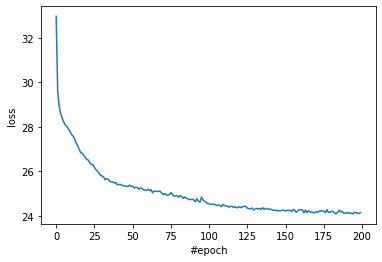

In [27]:
fig = plt.figure()
ax = fig.add_subplot()
if type==1:
  ax.plot(list(range(len(epoch_loss1))), epoch_loss1)
if type==2:
  ax.plot(list(range(len(epoch_loss2))), epoch_loss2)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

O (1797, 64)


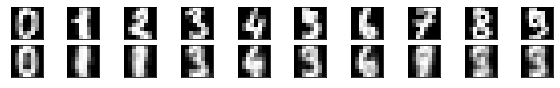

In [28]:
n_img2=10
#x3=x[:n_img2]
x2 = x_train.clone().detach()
x3=x2[:n_img2]

torch.reshape( x2, (-1,n_in) )

loss = vae( x2 )

o = vae.net.out.to('cpu').detach().numpy().copy()
print("O",o.shape)

plt.figure( figsize=(10,2))
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x3[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

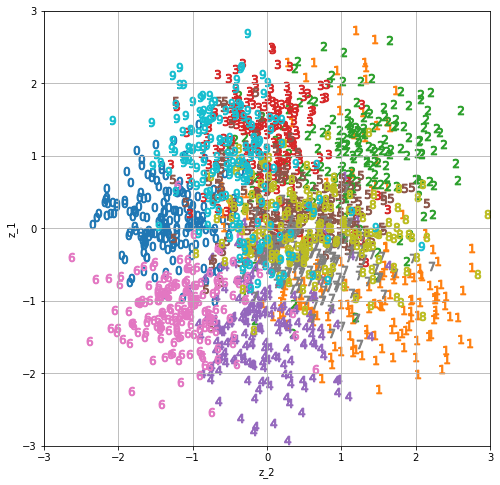

In [29]:
t2 = t_train #[:n_batch]

x2 = x_train.clone().detach()
torch.reshape( x2, (-1,n_in) )
loss = vae( x2 )

plt.figure(figsize=(8,8))
for i in range(10):
  zt = vae.net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

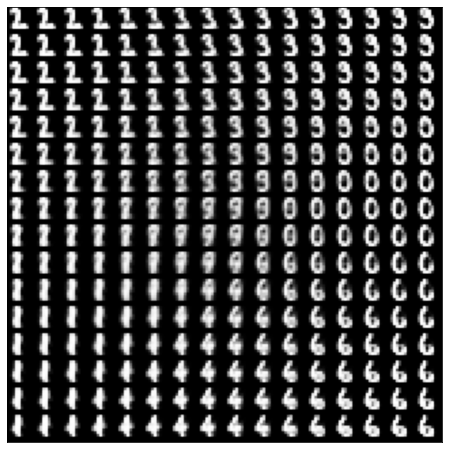

In [30]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( vae.net.fc3(zz) )
      o = torch.sigmoid( vae.net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

学習の実行(C++)